In [54]:
%matplotlib inline
import matplotlib.pylab

In [55]:
import os
import mne
import glob
import matplotlib
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from pylab import savefig

import copy

import pylab as pl
'''
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score, LeaveOneOut, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, r2_score, f1_score, matthews_corrcoef
from sklearn.decomposition import PCA
'''
from IPython.display import display

import glob

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

height has been deprecated.



In [56]:
pfs = [ 1,  2,  4, 10, 12, 13, 17, 18, 21, 22, 23, 24, 26, 29, 30, 31, 34, 37, 38] # [24] (S25) is full of nan
pws = [ 0,  3,  5,  6,  7,  8,  9, 11, 14, 15, 16, 19, 20, 25, 27, 28, 32, 33, 35, 36]

pws_bin = np.zeros(39)
pws_bin[pws] = 1

In [57]:
roidir = '/Users/kevinsitek/om/om/user/ksitek/STUT/scripts/ptx2/conn_out_roi/'
subdir = '/Users/kevinsitek/om/om/user/ksitek/STUT/ptx2/scripts/ptx2/conn_out_subj/'

In [6]:
if ~os.path.isdir(roidir):
    os.system("sshfs ~/om ksitek@openmind7.mit.edu:/")

In [58]:
roi_db = pd.read_csv(roidir + 'roi_list.csv',header=None)
roi_array = np.array(roi_db)
roi_list = []
for r in roi_array:
    print r
    roi_list = np.append(roi_list, str(r).translate(None,'[] \''))

['Brain-Stem']
['wm-lh-unknown']
['wm-lh-rostralmiddlefrontal']
['wm-lh-superiorfrontal']
['wm-lh-caudalmiddlefrontal']
['wm-lh-lateralorbitofrontal']
['wm-lh-frontalpole']
['wm-lh-medialorbitofrontal']
['wm-lh-parstriangularis']
['wm-lh-parsorbitalis']
['wm-lh-parsopercularis']
['wm-lh-paracentral']
['wm-lh-precentral']
['wm-lh-postcentral']
['wm-lh-bankssts']
['wm-lh-middletemporal']
['wm-lh-superiortemporal']
['wm-lh-transversetemporal']
['wm-lh-fusiform']
['wm-lh-inferiortemporal']
['wm-lh-parahippocampal']
['wm-lh-temporalpole']
['wm-lh-entorhinal']
['wm-lh-precuneus']
['wm-lh-inferiorparietal']
['wm-lh-supramarginal']
['wm-lh-superiorparietal']
['wm-lh-lateraloccipital']
['wm-lh-lingual']
['wm-lh-cuneus']
['wm-lh-pericalcarine']
['wm-lh-isthmuscingulate']
['wm-lh-posteriorcingulate']
['wm-lh-rostralanteriorcingulate']
['wm-lh-caudalanteriorcingulate']
['wm-lh-insula']
['Left-Pallidum']
['Left-VentralDC']
['Left-Thalamus-Proper']
['Left-Amygdala']
['Left-Accumbens-area']
['Left-Hi

## Rename and regroup ROIs

In [59]:
roi_list.shape

(91,)

Second reordering of ROIs to make a symmetrical, anatomically ordered plot - 9/9

2016-03-19: removing wm-unknown

In [60]:
# want the mne circle plot to have anterior on left, posterior on right, with rh on top and lh on bottom
# start with posterior rh

anat_order = ['Brain-Stem',\
              'Right-Cerebellum-Cortex','Right-Cerebellum-White-Matter',\
              'Right-VentralDC','Right-Thalamus-Proper','Right-Pallidum','Right-Putamen','Right-Caudate', 'Right-Hippocampus','Right-Amygdala','Right-Accumbens-area',\
              'wm-rh-lateraloccipital','wm-rh-lingual','wm-rh-cuneus','wm-rh-pericalcarine',\
              'wm-rh-precuneus','wm-rh-superiorparietal','wm-rh-inferiorparietal','wm-rh-supramarginal',\
              'wm-rh-parahippocampal','wm-rh-entorhinal','wm-rh-fusiform','wm-rh-inferiortemporal','wm-rh-temporalpole','wm-rh-middletemporal','wm-rh-transversetemporal','wm-rh-bankssts','wm-rh-superiortemporal',\
              'wm-rh-insula',\
              'wm-rh-posteriorcingulate','wm-rh-isthmuscingulate','wm-rh-caudalanteriorcingulate','wm-rh-rostralanteriorcingulate',\
              'wm-rh-paracentral','wm-rh-postcentral','wm-rh-precentral', \
              'wm-rh-parsopercularis','wm-rh-parstriangularis','wm-rh-parsorbitalis','wm-rh-lateralorbitofrontal','wm-rh-caudalmiddlefrontal','wm-rh-medialorbitofrontal','wm-rh-rostralmiddlefrontal','wm-rh-superiorfrontal','wm-rh-frontalpole',\
              'wm-lh-frontalpole','wm-lh-superiorfrontal', 'wm-lh-rostralmiddlefrontal','wm-lh-medialorbitofrontal','wm-lh-caudalmiddlefrontal', \
              'wm-lh-lateralorbitofrontal','wm-lh-parsorbitalis','wm-lh-parstriangularis','wm-lh-parsopercularis',\
              'wm-lh-precentral','wm-lh-postcentral','wm-lh-paracentral','wm-lh-rostralanteriorcingulate', \
              'wm-lh-caudalanteriorcingulate','wm-lh-posteriorcingulate','wm-lh-isthmuscingulate','wm-lh-insula',\
              'wm-lh-superiortemporal','wm-lh-bankssts','wm-lh-transversetemporal','wm-lh-middletemporal', \
              'wm-lh-temporalpole','wm-lh-inferiortemporal','wm-lh-fusiform','wm-lh-entorhinal','wm-lh-parahippocampal',\
              'wm-lh-supramarginal',\
              'wm-lh-inferiorparietal','wm-lh-superiorparietal','wm-lh-precuneus','wm-lh-pericalcarine','wm-lh-cuneus',\
              'wm-lh-lingual','wm-lh-lateraloccipital','Left-Accumbens-area','Left-Amygdala', \
              'Left-Hippocampus','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Thalamus-Proper','Left-VentralDC', \
              'Left-Cerebellum-White-Matter','Left-Cerebellum-Cortex']  #'wm-rh-inferiortemporal',
'''order:
[brainstem, right_cerebellum, right_subcort, right_cortex, right_occipital, right_parietal, \
right_temporal, right_insula, right_cingulate,right_frontal,right_central_frontal,right_medinf_frontal, \
right_suplat_frontal,left_suplat_frontal,left_medinf_frontal,left_central_frontal,left_frontal, \
left_cingulate,left_insula,left_suplat_temporal,left_medinf_temporal,left_temporal,left_parietal,left_occipital, \
left_cortex,left_subcort, left_cerebellum])
'''
anat_order.reverse()
anat_num_order = np.zeros((len(anat_order),1))
for ax,anat in enumerate(anat_order):
    anat_num_order[ax] = int(list(roi_list).index(anat))


In [61]:
print anat_num_order.shape
print anat_num_order[:5]

(89, 1)
[[ 44.]
 [ 45.]
 [ 37.]
 [ 38.]
 [ 36.]]


In [40]:
with open(roidir+'anat_num_order.txt', 'w') as file:
    for item in anat_num_order:
        file.write("{}\n".format(item))
'''        
roi_list_reorder = []
for r in roi_list[roi_reorder]:
    roi_list_reorder.append(str(r))
print roi_list_reorder
'''
with open(roidir+'anat_order.txt', 'w') as file:
    for item in anat_order:
        file.write("{}\n".format(item))

Run 9/2, then reran ptx2_grp.py with new ROI list - no longer necessary to use reorder files

<b> Realized 9/9 that this is missing rh-inferiortemporal</b>

In [62]:
# separate into sublists
brainstem = []
left_cortex = []
left_frontal = []
left_suplat_frontal = []
left_medinf_frontal = []
left_central_frontal = []
left_temporal = []
left_suplat_temporal = []
left_medinf_temporal = []
left_parietal = []
left_occipital = []
left_cingulate = []
left_insula = []
left_subcort = []
left_cerebellum = []

right_cortex = []
right_frontal = []
right_suplat_frontal = []
right_medinf_frontal = []
right_central_frontal = []
right_temporal = []
right_suplat_temporal = []
right_medinf_temporal = []
right_parietal = []
right_occipital = []
right_cingulate = []
right_insula = []
right_subcort = []
right_cerebellum = []

roi_brainstem_reorder = []
roi_left_cortex_reorder = []
roi_left_frontal_reorder = []
roi_left_suplat_frontal_reorder = []
roi_left_medinf_frontal_reorder = []
roi_left_central_frontal_reorder = []
roi_left_temporal_reorder = []
roi_left_suplat_temporal_reorder = []
roi_left_medinf_temporal_reorder = []
roi_left_parietal_reorder = []
roi_left_occipital_reorder = []
roi_left_cingulate_reorder = []
roi_left_insula_reorder = []
roi_left_subcort_reorder = []
roi_left_cerebellum_reorder = []
roi_right_cortex_reorder = []
roi_right_frontal_reorder = []
roi_right_suplat_frontal_reorder = []
roi_right_medinf_frontal_reorder = []
roi_right_central_frontal_reorder = []
roi_right_temporal_reorder = []
roi_right_suplat_temporal_reorder = []
roi_right_medinf_temporal_reorder = []
roi_right_parietal_reorder = []
roi_right_occipital_reorder = []
roi_right_cingulate_reorder = []
roi_right_insula_reorder = []
roi_right_subcort_reorder = []
roi_right_cerebellum_reorder = []

rx = 0
roi_reorder = []
for roi in roi_list:
    if 'Brain-Stem' in roi:
        brainstem.append(roi)
        roi_brainstem_reorder.append(rx)
    elif 'lh-' in roi:
        if 'parstriangularis' in roi or 'parsorbitalis' in roi or 'parsopercularis' in roi:
            left_suplat_frontal.append(roi)
            roi_left_suplat_frontal_reorder.append(rx)
        elif 'central' in roi:
            left_central_frontal.append(roi)
            roi_left_central_frontal_reorder.append(rx)
        elif 'frontal' in roi:
            left_frontal.append(roi)
            roi_left_frontal_reorder.append(rx)
        elif 'sts' in roi or 'middletemporal' in roi \
            or 'superiortemporal' in roi or 'transversetemporal' in roi:
            left_suplat_temporal.append(roi)
            roi_left_suplat_temporal_reorder.append(rx)
        elif 'inferiortemporal' in roi or 'entorhinal' in roi or 'fusiform' in roi \
            or 'parahippocampal' in roi or 'temporalpole' in roi:
            left_medinf_temporal.append(roi)
            roi_left_medinf_temporal_reorder.append(rx)
        elif 'parietal' in roi or 'postcentral' in roi or 'supramarginal' in roi or 'precuneus' in roi:
            left_parietal.append(roi)
            roi_left_parietal_reorder.append(rx)
        elif 'occipital' in roi or 'cuneus' in roi or 'calcarine' in roi or 'lingual' in roi:
            left_occipital.append(roi)
            roi_left_occipital_reorder.append(rx)
        elif 'cingulate' in roi:
            left_cingulate.append(roi)
            roi_left_cingulate_reorder.append(rx)
        elif 'insula' in roi:
            left_insula.append(roi)
            roi_left_insula_reorder.append(rx)
        else:
            left_cortex.append(roi)
            roi_left_cortex_reorder.append(rx)
    elif 'Left-' in roi:
        if 'Cerebellum' in roi:
            left_cerebellum.append(roi)
            roi_left_cerebellum_reorder.append(rx)
        else:
            left_subcort.append(roi)
            roi_left_subcort_reorder.append(rx)
    elif 'rh-' in roi:
        if 'parstriangularis' in roi or 'parsorbitalis' in roi or 'parsopercularis' in roi:
            right_suplat_frontal.append(roi)
            roi_right_suplat_frontal_reorder.append(rx)
        elif 'central' in roi:
            right_central_frontal.append(roi)
            roi_right_central_frontal_reorder.append(rx)
        elif 'frontal' in roi:
            right_frontal.append(roi)
            roi_right_frontal_reorder.append(rx)
        elif 'sts' in roi or 'middletemporal' in roi \
            or 'superiortemporal' in roi or 'transversetemporal' in roi:
            right_suplat_temporal.append(roi)
            roi_right_suplat_temporal_reorder.append(rx)
        elif 'inferiortemporal' in roi or 'entorhinal' in roi or 'fusiform' in roi \
            or 'parahippocampal' in roi or 'temporalpole' in roi:
            right_medinf_temporal.append(roi)
            roi_right_medinf_temporal_reorder.append(rx)
        elif 'parietal' in roi or 'postcentral' in roi or 'supramarginal' in roi or 'precuneus' in roi:
            right_parietal.append(roi)
            roi_right_parietal_reorder.append(rx)
        elif 'occipital' in roi or 'cuneus' in roi or 'calcarine' in roi or 'lingual' in roi:
            right_occipital.append(roi)
            roi_right_occipital_reorder.append(rx)
        elif 'cingulate' in roi:
            right_cingulate.append(roi)
            roi_right_cingulate_reorder.append(rx)
        elif 'insula' in roi:
            right_insula.append(roi)
            roi_right_insula_reorder.append(rx)
        else:
            right_cortex.append(roi)
            roi_right_cortex_reorder.append(rx)
    elif 'Right-' in roi:
        if 'Cerebellum' in roi:
            right_cerebellum.append(roi)
            roi_right_cerebellum_reorder.append(rx)
        else:
            right_subcort.append(roi)
            roi_right_subcort_reorder.append(rx)
    rx += 1

# combine lists into new numerical order for ROIs
roi_reorder = roi_brainstem_reorder + roi_left_cortex_reorder + roi_left_frontal_reorder + \
            roi_left_suplat_frontal_reorder + roi_left_medinf_frontal_reorder + \
            roi_left_central_frontal_reorder + roi_left_temporal_reorder + \
            roi_left_suplat_temporal_reorder + roi_left_medinf_temporal_reorder + \
            roi_left_parietal_reorder + roi_left_occipital_reorder + roi_left_cingulate_reorder + \
            roi_left_insula_reorder + roi_left_subcort_reorder + roi_left_cerebellum_reorder + \
            roi_right_cortex_reorder + roi_right_frontal_reorder + \
            roi_right_suplat_frontal_reorder + roi_right_medinf_frontal_reorder + \
            roi_right_central_frontal_reorder + roi_right_temporal_reorder + \
            roi_right_suplat_temporal_reorder + roi_right_medinf_temporal_reorder + \
            roi_right_parietal_reorder + roi_right_occipital_reorder + roi_right_cingulate_reorder + \
            roi_right_insula_reorder + roi_right_subcort_reorder + roi_right_cerebellum_reorder
print roi_reorder


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [63]:
with open(roidir+'roi_num_reorder.txt', 'w') as file:
    for item in roi_reorder:
        file.write("{}\n".format(item))
        
roi_list_reorder = []
for r in roi_list[roi_reorder]:
    roi_list_reorder.append(str(r))
print roi_list_reorder

with open(roidir+'roi_list_reorder.txt', 'w') as file:
    for item in roi_list_reorder:
        file.write("{}\n".format(item))
        

['Brain-Stem', 'wm-lh-unknown', 'wm-lh-rostralmiddlefrontal', 'wm-lh-superiorfrontal', 'wm-lh-caudalmiddlefrontal', 'wm-lh-lateralorbitofrontal', 'wm-lh-frontalpole', 'wm-lh-medialorbitofrontal', 'wm-lh-parstriangularis', 'wm-lh-parsorbitalis', 'wm-lh-parsopercularis', 'wm-lh-paracentral', 'wm-lh-precentral', 'wm-lh-postcentral', 'wm-lh-bankssts', 'wm-lh-middletemporal', 'wm-lh-superiortemporal', 'wm-lh-transversetemporal', 'wm-lh-fusiform', 'wm-lh-inferiortemporal', 'wm-lh-parahippocampal', 'wm-lh-temporalpole', 'wm-lh-entorhinal', 'wm-lh-precuneus', 'wm-lh-inferiorparietal', 'wm-lh-supramarginal', 'wm-lh-superiorparietal', 'wm-lh-lateraloccipital', 'wm-lh-lingual', 'wm-lh-cuneus', 'wm-lh-pericalcarine', 'wm-lh-isthmuscingulate', 'wm-lh-posteriorcingulate', 'wm-lh-rostralanteriorcingulate', 'wm-lh-caudalanteriorcingulate', 'wm-lh-insula', 'Left-Pallidum', 'Left-VentralDC', 'Left-Thalamus-Proper', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-Hippocampus', 'Left-Putamen', 'Left-Caudate

In [64]:
print roi_list[roi_reorder]

['Brain-Stem' 'wm-lh-unknown' 'wm-lh-rostralmiddlefrontal'
 'wm-lh-superiorfrontal' 'wm-lh-caudalmiddlefrontal'
 'wm-lh-lateralorbitofrontal' 'wm-lh-frontalpole'
 'wm-lh-medialorbitofrontal' 'wm-lh-parstriangularis' 'wm-lh-parsorbitalis'
 'wm-lh-parsopercularis' 'wm-lh-paracentral' 'wm-lh-precentral'
 'wm-lh-postcentral' 'wm-lh-bankssts' 'wm-lh-middletemporal'
 'wm-lh-superiortemporal' 'wm-lh-transversetemporal' 'wm-lh-fusiform'
 'wm-lh-inferiortemporal' 'wm-lh-parahippocampal' 'wm-lh-temporalpole'
 'wm-lh-entorhinal' 'wm-lh-precuneus' 'wm-lh-inferiorparietal'
 'wm-lh-supramarginal' 'wm-lh-superiorparietal' 'wm-lh-lateraloccipital'
 'wm-lh-lingual' 'wm-lh-cuneus' 'wm-lh-pericalcarine'
 'wm-lh-isthmuscingulate' 'wm-lh-posteriorcingulate'
 'wm-lh-rostralanteriorcingulate' 'wm-lh-caudalanteriorcingulate'
 'wm-lh-insula' 'Left-Pallidum' 'Left-VentralDC' 'Left-Thalamus-Proper'
 'Left-Amygdala' 'Left-Accumbens-area' 'Left-Hippocampus' 'Left-Putamen'
 'Left-Caudate' 'Left-Cerebellum-Cortex' '

In [65]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 10))
for r in range(len(anat_order)):
    if r == 0:
        color_list = ['black']
    elif r <= 2:
        color_list.append(colors[1])
    elif r <= 10:
        color_list.append(colors[2])
    elif r <= 11:
        color_list.append(colors[3])
    elif r <= 15:
        color_list.append(colors[4])
    elif r <= 19:
        color_list.append(colors[5])
    elif r <= 27:
        color_list.append(colors[6])
    elif r <= 28:
        color_list.append(colors[7])
    elif r <= 32:
        color_list.append(colors[8])
    elif r <= 35:
        color_list.append(colors[9])
    elif r <= 44:
        color_list.append(colors[0])
    elif r <= 53:
        color_list.append(colors[0])
    elif r <= 56:
        color_list.append(colors[9])
    elif r <= 60:
        color_list.append(colors[8])
    elif r <= 61:
        color_list.append(colors[7])
    elif r <= 69:
        color_list.append(colors[6])
    elif r <= 73:
        color_list.append(colors[5])
    elif r <= 77:
        color_list.append(colors[4])
    elif r <= 78:
        color_list.append(colors[3])
    elif r <= 86:
        color_list.append(colors[2])
    else:
        color_list.append(colors[1])
color_list.reverse()

In [66]:
roi_list_sh = []
for r in anat_order:#roi_list:
    if r[0:3] == 'wm-':
        roi_list_sh.append(r[6:])
    elif r[0:5] == 'Left-':
        roi_list_sh.append(r[5:])
    elif r[0:6] == 'Right-':
        roi_list_sh.append(r[6:])
    else:
        roi_list_sh.append(r)



In [67]:
print len(roi_list_sh)
print roi_list_sh

89
['Cerebellum-Cortex', 'Cerebellum-White-Matter', 'VentralDC', 'Thalamus-Proper', 'Pallidum', 'Putamen', 'Caudate', 'Hippocampus', 'Amygdala', 'Accumbens-area', 'lateraloccipital', 'lingual', 'cuneus', 'pericalcarine', 'precuneus', 'superiorparietal', 'inferiorparietal', 'supramarginal', 'parahippocampal', 'entorhinal', 'fusiform', 'inferiortemporal', 'temporalpole', 'middletemporal', 'transversetemporal', 'bankssts', 'superiortemporal', 'insula', 'isthmuscingulate', 'posteriorcingulate', 'caudalanteriorcingulate', 'rostralanteriorcingulate', 'paracentral', 'postcentral', 'precentral', 'parsopercularis', 'parstriangularis', 'parsorbitalis', 'lateralorbitofrontal', 'caudalmiddlefrontal', 'medialorbitofrontal', 'rostralmiddlefrontal', 'superiorfrontal', 'frontalpole', 'frontalpole', 'superiorfrontal', 'rostralmiddlefrontal', 'medialorbitofrontal', 'caudalmiddlefrontal', 'lateralorbitofrontal', 'parsorbitalis', 'parstriangularis', 'parsopercularis', 'precentral', 'postcentral', 'paracen

**Import stuttering severity instrument 4 data**

In [68]:
## 
ssi_csv = pd.read_csv('/Users/kevinsitek/Dropbox (MIT)/projects/stuttering/ssi.csv')
ssi = ssi_csv['SSI']

target_ssi = np.array(ssi)
target_ssi[pfs] = 0
target = map(int,target_ssi)
data_status = map(int,np.array(pws_bin)) # only pws (??)

print target_ssi
print target
print data_status

['23' 0 0 '20' 0 '32' '43' '30' '17' '23' 0 '34' 0 0 '37' '30' '16' 0 0
 '28' '20' 0 0 0 0 '27' 0 '16' '25' 0 0 0 '13' '17' 0 '29' '36' 0 0]
[23, 0, 0, 20, 0, 32, 43, 30, 17, 23, 0, 34, 0, 0, 37, 30, 16, 0, 0, 28, 20, 0, 0, 0, 0, 27, 0, 16, 25, 0, 0, 0, 13, 17, 0, 29, 36, 0, 0]
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]


In [69]:
# align rs correlation matrix with SSI subject list
pws_ssi = np.zeros(len(pws))
#target[np.array(pws)]
for i, p in enumerate(pws):
    pws_ssi[i] = target[p]
print pws_ssi

[ 23.  20.  32.  43.  30.  17.  23.  34.  37.  30.  16.  28.  20.  27.  16.
  25.  13.  17.  29.  36.]


## Per-ROI statistics

## Network

### ROI network strength

In [70]:
len(roi_list_sh)

89

In [71]:
#for roi in glob.glob(roidir + '*-*.txt'):
strength = np.zeros((39,len(roi_list_sh)))
strength_t = np.zeros((len(roi_list_sh),1))
strength_p = np.zeros((len(roi_list_sh),1))

print "PFS>PWS group differences"
for rx,roi in enumerate(anat_order):#roi_list:
    roi_mat = np.loadtxt(roidir + roi + '.txt')
    
    strength[:,rx] = np.sum(roi_mat,1)
    
    pfs_mat = strength[pfs,rx]
    pws_mat = strength[pws,rx]

    # avoid nan values
    pfs_finite = pfs_mat[np.isfinite(pfs_mat)]
    pws_finite = pws_mat[np.isfinite(pws_mat)]

    t, p = scipy.stats.ttest_ind(pfs_mat, pws_mat)
    strength_t[rx] = t
    strength_p[rx] = p

    if p <= 0.005:
        sig = '***'
    elif p <= 0.01:
        sig = ' **'
    elif p <=.02:
        sig = '  *'
    else:
        sig = '   '

    if p <= 0.05:
        print " %st = %1.2f;  p = %1.3f; ROI: %s" % (sig, t, p, roi)#roi_list[r])

print ""
print "PWS ROI strength correlations with SSI"
for rx,roi in enumerate(anat_order):#roi_list:
    roi_mat = np.loadtxt(roidir + roi + '.txt')
    
    strength[:,rx] = np.sum(roi_mat,1)
    
    pfs_mat = strength[pfs,rx]
    pws_mat = strength[pws,rx]
    pearsons_r,pearsons_p = (scipy.stats.pearsonr(pws_mat,np.array(pws_ssi)))


    if pearsons_p <= 0.001:
        sig = '***'
    elif pearsons_p <= 0.005:
        sig = ' **'
    elif pearsons_p <= 0.01:
        sig = '  *'
    else:
        sig = '   '

    if pearsons_p <= 0.05:
        print "%1.2f;%1.3f;%s" % (pearsons_r, pearsons_p, roi)

PFS>PWS group differences
  **t = 2.79;  p = 0.008; ROI: wm-lh-parstriangularis
    t = 2.03;  p = 0.050; ROI: wm-lh-lateralorbitofrontal

PWS ROI strength correlations with SSI
-0.47;0.035;wm-lh-pericalcarine
-0.46;0.041;wm-lh-precuneus
-0.62;0.004;wm-lh-superiorparietal
-0.51;0.020;wm-lh-transversetemporal
-0.50;0.025;wm-lh-bankssts
-0.50;0.026;wm-lh-superiortemporal
-0.45;0.045;wm-lh-isthmuscingulate
-0.47;0.035;wm-lh-paracentral
-0.50;0.025;wm-lh-precentral
-0.56;0.011;wm-lh-parsorbitalis
-0.47;0.038;wm-lh-caudalmiddlefrontal
-0.49;0.029;wm-lh-superiorfrontal
-0.48;0.034;wm-rh-insula
-0.58;0.007;wm-rh-temporalpole
-0.48;0.032;wm-rh-precuneus
-0.45;0.049;Right-Putamen
-0.56;0.010;Right-Cerebellum-White-Matter
-0.57;0.008;Right-Cerebellum-Cortex


# Symmetric connectivity matrices

Create a symmetric matrix by averaging [rx,cx] and [cx,rx] (per Cai et al. 2014)

In [72]:
print roi_list
print anat_order

['Brain-Stem' 'wm-lh-unknown' 'wm-lh-rostralmiddlefrontal'
 'wm-lh-superiorfrontal' 'wm-lh-caudalmiddlefrontal'
 'wm-lh-lateralorbitofrontal' 'wm-lh-frontalpole'
 'wm-lh-medialorbitofrontal' 'wm-lh-parstriangularis' 'wm-lh-parsorbitalis'
 'wm-lh-parsopercularis' 'wm-lh-paracentral' 'wm-lh-precentral'
 'wm-lh-postcentral' 'wm-lh-bankssts' 'wm-lh-middletemporal'
 'wm-lh-superiortemporal' 'wm-lh-transversetemporal' 'wm-lh-fusiform'
 'wm-lh-inferiortemporal' 'wm-lh-parahippocampal' 'wm-lh-temporalpole'
 'wm-lh-entorhinal' 'wm-lh-precuneus' 'wm-lh-inferiorparietal'
 'wm-lh-supramarginal' 'wm-lh-superiorparietal' 'wm-lh-lateraloccipital'
 'wm-lh-lingual' 'wm-lh-cuneus' 'wm-lh-pericalcarine'
 'wm-lh-isthmuscingulate' 'wm-lh-posteriorcingulate'
 'wm-lh-rostralanteriorcingulate' 'wm-lh-caudalanteriorcingulate'
 'wm-lh-insula' 'Left-Pallidum' 'Left-VentralDC' 'Left-Thalamus-Proper'
 'Left-Amygdala' 'Left-Accumbens-area' 'Left-Hippocampus' 'Left-Putamen'
 'Left-Caudate' 'Left-Cerebellum-Cortex' '

In [73]:
print len(roi_list)
print len(anat_order)

91
89


In [74]:
# make 3-D matrix
roi_mat3d = np.zeros((39,len(roi_list),len(roi_list)))

for rx,roi in enumerate(roi_list):#(anat_order):
    roi_mat = np.loadtxt(roidir + roi + '.txt')
    roi = (roi).replace('.txt','').replace('wm-','')

    roi_mat3d[:,rx,:] = roi_mat

In [75]:
# make the symmetrical matrix
symm_roi_mat3d = np.zeros(roi_mat3d.shape)

for sx in range(symm_roi_mat3d.shape[0]):
    for rx in range(symm_roi_mat3d.shape[1]):
        for cx in range(symm_roi_mat3d.shape[2]):
            symm_roi_mat3d[sx,rx,cx] = 0.5*(roi_mat3d[sx,rx,cx] + roi_mat3d[sx,cx,rx])   

In [76]:
print anat_num_order.shape
print anat_num_order[:5]

(89, 1)
[[ 44.]
 [ 45.]
 [ 37.]
 [ 38.]
 [ 36.]]


In [77]:
t_mat_symm = np.zeros((len(anat_order),len(anat_order)))
p_mat_symm = np.zeros((len(anat_order),len(anat_order)))
p05x = 0
p03x = 0

for irx,rx in enumerate(anat_num_order):#range(symm_roi_mat3d.shape[1]):
    rx = int(rx)
    for icx,cx in enumerate(anat_num_order):#range(symm_roi_mat3d.shape[2]):
        cx = int(cx)
        
        pfs_symm = symm_roi_mat3d[pfs,rx,cx]
        pws_symm = symm_roi_mat3d[pws,rx,cx]
        
        #t, p = scipy.stats.ttest_ind(pfs_symm, pws_symm)
        t, p = scipy.stats.ranksums(pfs_symm, pws_symm)
        t_mat_symm[irx,icx] = t
        p_mat_symm[irx,icx] = p

        if p <= 0.005:
            sig = '***'
        elif p <= 0.01:
            sig = ' **'
        elif p <=.02:
            sig = '  *'
        else:
            sig = '   '
        if p <= 0.03:
            p03x += 1
        if p <= 0.05:
            print " %st = %1.2f;  p = %1.3f; seed: %s - target: %s" % (sig, t, p, roi_list[rx], roi_list[cx])
            p05x += 1

    t = 2.14;  p = 0.033; seed: Left-Cerebellum-Cortex - target: wm-lh-superiortemporal
    t = -1.99;  p = 0.046; seed: Left-VentralDC - target: Right-Caudate
   *t = -2.53;  p = 0.011; seed: Left-Pallidum - target: Left-Accumbens-area
    t = -2.28;  p = 0.023; seed: Left-Pallidum - target: wm-lh-cuneus
    t = 2.08;  p = 0.038; seed: Left-Pallidum - target: wm-lh-isthmuscingulate
    t = 1.97;  p = 0.049; seed: Left-Putamen - target: Left-Caudate
    t = 1.97;  p = 0.049; seed: Left-Caudate - target: Left-Putamen
  **t = -2.70;  p = 0.007; seed: Left-Caudate - target: wm-rh-frontalpole
    t = 2.14;  p = 0.033; seed: Left-Amygdala - target: wm-lh-cuneus
   *t = -2.53;  p = 0.011; seed: Left-Accumbens-area - target: Left-Pallidum
    t = -2.14;  p = 0.033; seed: Left-Accumbens-area - target: wm-rh-rostralanteriorcingulate
    t = -2.14;  p = 0.033; seed: wm-lh-lingual - target: Right-Accumbens-area
    t = -2.02;  p = 0.043; seed: wm-lh-lingual - target: Right-Caudate
    t = -2.28; 

In [78]:
print p03x
print p05x

26
84


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
print len(roi_list_sh)
print t_mat_symm.shape

89
(89, 89)


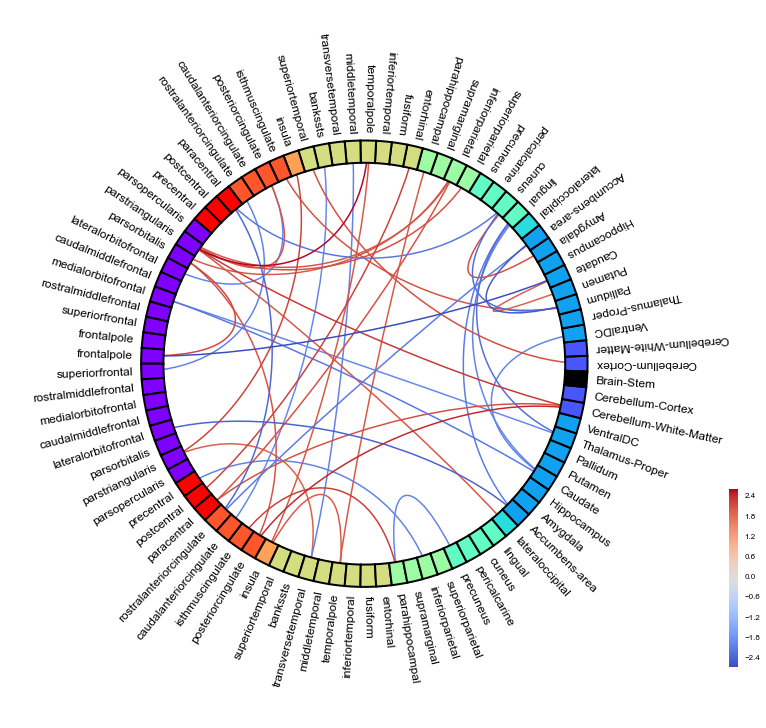

In [82]:
t_mask = copy.copy(t_mat_symm)
#t_mask[abs(t_mask) < 2.0] = 0
t_mask[p_mat_symm > .05] = 0

roi_list_mask = []
for rx,r in enumerate(roi_list_sh):
    if np.nanmean(t_mask[rx,:])!= 0 or np.nanmean(t_mask[:,rx])!= 0:
        roi_list_mask.append(r)
    else:
        roi_list_mask.append('')

fig = plt.figure(figsize = (16,16));
        
mne.viz.plot_connectivity_circle(t_mat_symm, roi_list_sh, indices=None, n_lines=p05x/2,
           node_angles=None, node_width=None, node_colors=color_list, facecolor='white',
           textcolor='black', node_edgecolor='black', linewidth=1.5, colormap='coolwarm',
           vmin=None, vmax=None, colorbar=True, title='', colorbar_size=0.2,
           colorbar_pos=(-0.3, 0.2), fontsize_title=12, fontsize_names=12,
           fontsize_colorbar=8, padding=6.0, fig=fig, subplot=111, interactive=False)
fig.savefig('diffusion_groupdiff.png',bbox_inches='tight',dpi=300)

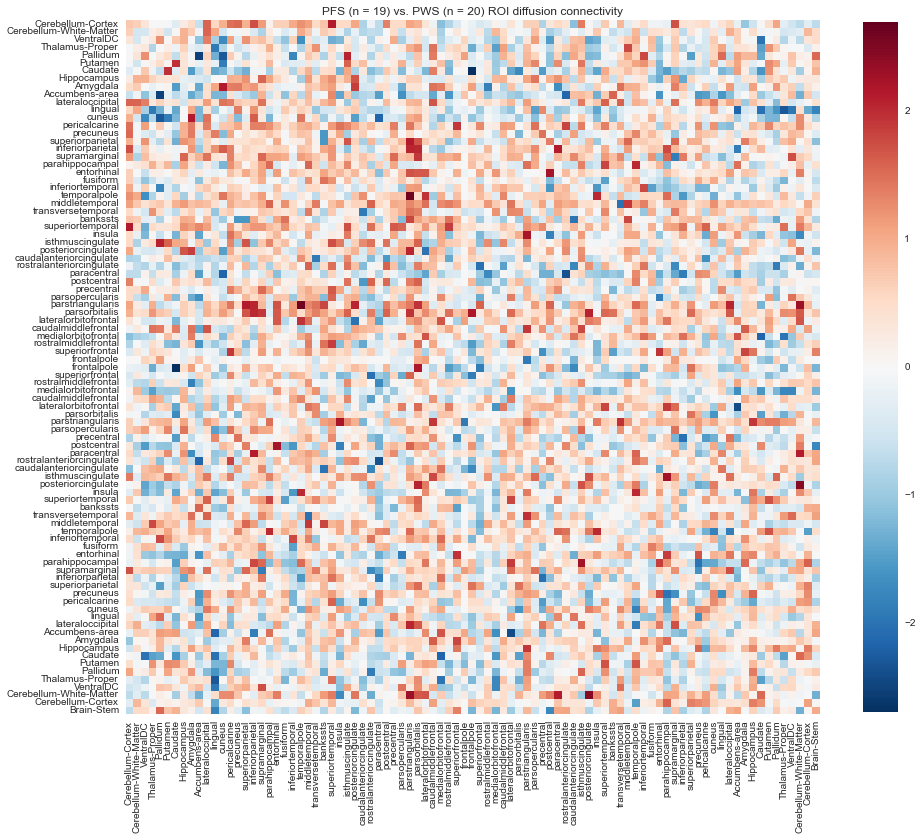

In [31]:
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('PFS (n = %d) vs. PWS (n = %d) ROI diffusion connectivity'%(19,20))
sns.color_palette("RdBu_r")
sns.heatmap(t_mat_symm, square=True, ax=ax, xticklabels=roi_list_sh,yticklabels=roi_list_sh,cbar_kws={'shrink':0.73})
f.tight_layout()

**Network-Based Statistic**

In [36]:
import nipype.interfaces.cmtk as cmtk

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/rdflib/__init__.py:95: ImportWarning: You are using a narrow Python build!
This means that your Python does not properly support chars > 16bit.
On your system chars like c=u"\U0010FFFF" will have a len(c)==2.
As this can cause hard to debug problems with string processing
(slicing, regexp, ...) later on, we strongly advise to use a wide
Python build in production systems.
  ImportWarning)


In [43]:
pws_files = []
pfs_files = []

for s in range(symm_roi_mat3d.shape[0]):
    sub_symm_mat = symm_roi_mat3d[s,:,:]
    fname = 'S%02d_symm_mat.txt'%(s+1)
    np.savetxt(fname,sub_symm_mat)
    
    if data_status[s]:
        pws_files.append(fname)
    else:
        pfs_files.append(fname)

In [53]:
f = open("roi_list.txt", "w")
mylist = roi_list_sh
f.write("\n".join(map(lambda x: str(x), mylist)))
f.close()

In [52]:
with open('roi_list.txt') as thefile:
    for item in roi_list_sh:
          thefile.write("%s\n" % item)

IOError: File not open for writing

In [46]:
nbs = cmtk.NetworkBasedStatistic()
nbs.inputs.in_group1 = pfs_files 
nbs.inputs.in_group2 = pws_files 
nbs.run()

UnpicklingError: invalid load key, '7'.
Interface NetworkBasedStatistic failed to run. 

**Hierarchical clustering**

In [74]:
import scipy.cluster.hierarchy as hier

In [82]:
t_mat_symm.shape
len(roi_list_sh)

89

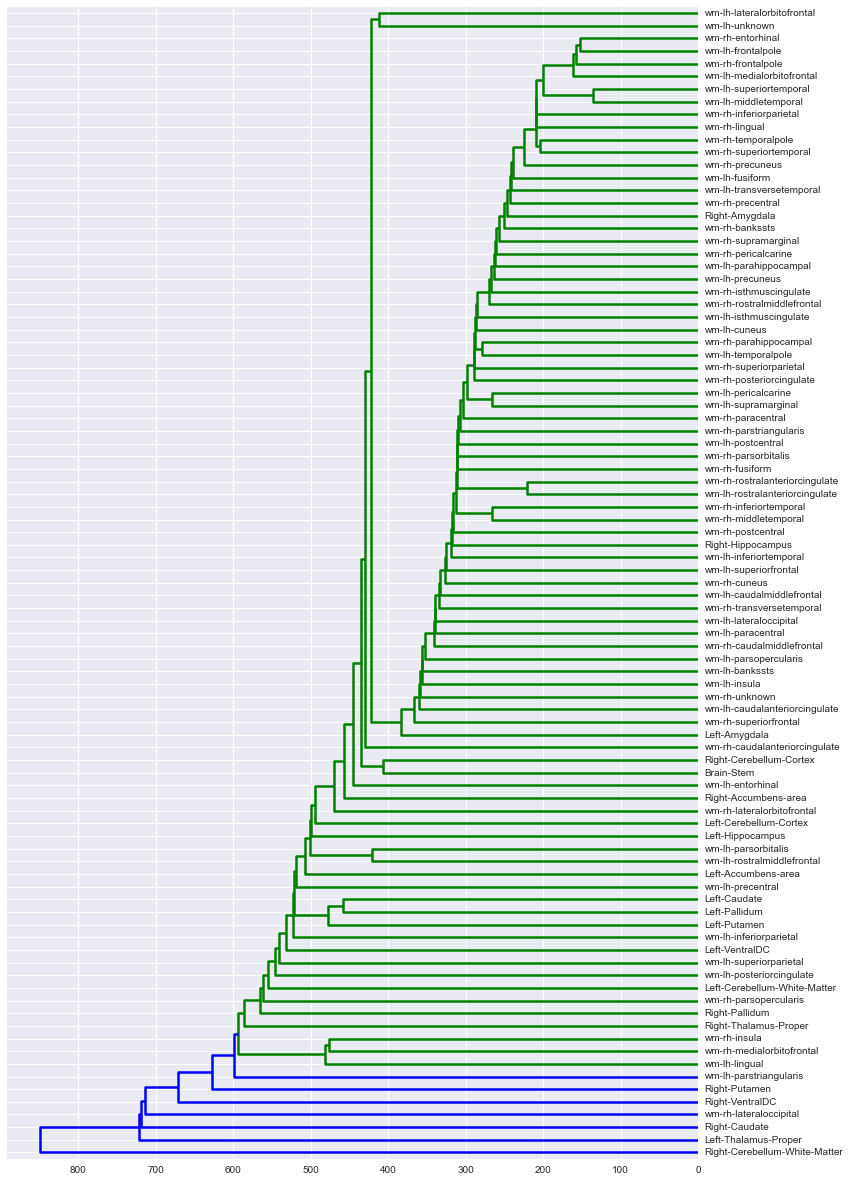

In [84]:
plt.figure(figsize=(12,20))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

X = np.mean(symm_roi_mat3d,axis=0)
Z = hier.linkage(X, 'single')
hier.dendrogram(Z, ax=ax,labels=roi_list, leaf_rotation=0, orientation='right');

**SSI correlations**

In [83]:
corrout_symm = np.zeros((t_mat_symm.shape[0],t_mat_symm.shape[0]))
pearsons_out_symm = np.zeros((t_mat_symm.shape[0],t_mat_symm.shape[0]))
pearsons_pvals_symm = np.zeros((t_mat_symm.shape[0],t_mat_symm.shape[0]))
pr005x = 0
pr01x = 0
for ir,r in enumerate(anat_num_order):#range(0,symm_roi_mat3d.shape[1]):
    r = int(r)
    rdat = symm_roi_mat3d[pws,r,:]
    for ic,c in enumerate(anat_num_order):#range(0,symm_roi_mat3d.shape[2]):
        c = int(c)
        corr_rc = (np.corrcoef(rdat[:,c],np.array(pws_ssi)))
        #print corr_rc
        corrout_symm[ir,ic] = corr_rc[0,1]
        
        pearsons_r,pearsons_p = (scipy.stats.pearsonr(rdat[:,c],np.array(pws_ssi)))

        pearsons_out_symm[ir,ic] = pearsons_r
        pearsons_pvals_symm[ir,ic] = pearsons_p
        
        if pearsons_p <= 0.0001:
            sig = '*****'
        elif pearsons_p <= 0.0005:
            sig = ' ****'
        elif pearsons_p <= 0.001:
            sig = '  ***'
        elif pearsons_p <= 0.005:
            sig = '   **'
            pr005x += 1
        elif pearsons_p <= 0.01:
            sig = '    *'
        else:
            sig = '     '
        
        if pearsons_p <= 0.01:
            print " %sr = %1.2f;  p = %1.5f; seed: %s - target: %s" % (sig, pearsons_r, pearsons_p, roi_list[r],roi_list[c])#anat_order[r], anat_order[c])
            pr01x += 1
        
#print corrout

    **r = -0.60;  p = 0.00499; seed: Left-Cerebellum-White-Matter - target: wm-lh-middletemporal
    **r = 0.65;  p = 0.00189; seed: Left-Cerebellum-White-Matter - target: wm-rh-rostralmiddlefrontal
    **r = -0.61;  p = 0.00421; seed: Left-VentralDC - target: wm-lh-parstriangularis
     *r = -0.57;  p = 0.00822; seed: Left-VentralDC - target: wm-rh-isthmuscingulate
     *r = -0.58;  p = 0.00679; seed: Left-VentralDC - target: wm-rh-cuneus
    **r = -0.61;  p = 0.00462; seed: Left-VentralDC - target: Brain-Stem
     *r = -0.60;  p = 0.00560; seed: Left-Thalamus-Proper - target: wm-rh-isthmuscingulate
     *r = -0.59;  p = 0.00604; seed: Left-Thalamus-Proper - target: Brain-Stem
     *r = 0.56;  p = 0.00946; seed: Left-Pallidum - target: wm-lh-temporalpole
    **r = -0.65;  p = 0.00186; seed: Left-Putamen - target: wm-lh-rostralmiddlefrontal
   ***r = -0.69;  p = 0.00085; seed: Left-Putamen - target: wm-rh-isthmuscingulate
    **r = -0.67;  p = 0.00117; seed: Left-Caudate - target: wm-r

In [84]:
print pr005x
print pr01x

60
151


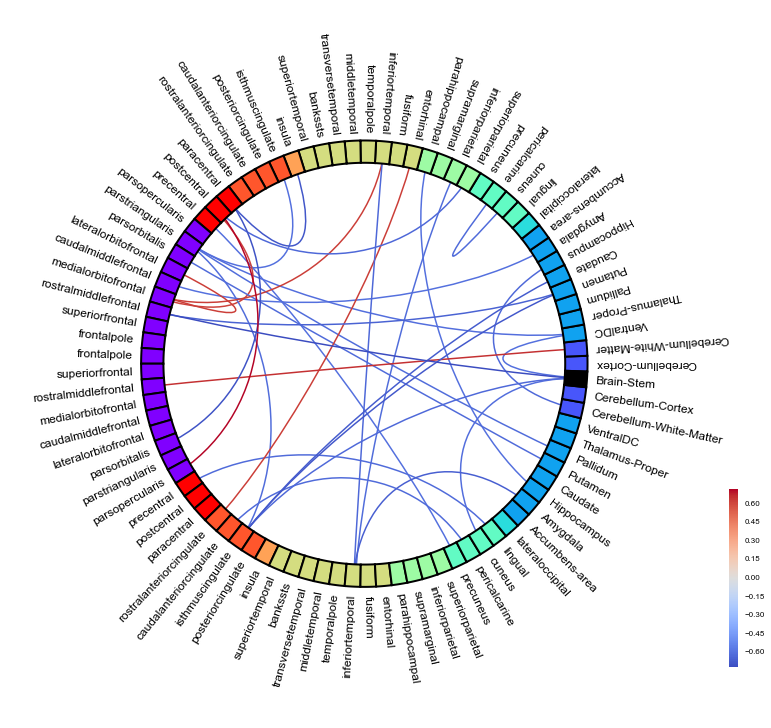

ValueError: Format "tif" is not supported.
Supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz.

In [87]:
r_mask = copy.copy(corrout_symm)
r_mask[pearsons_pvals_symm > .001] = 0

fig = plt.figure(figsize = (16,16));

mne.viz.plot_connectivity_circle(corrout_symm, roi_list_sh, indices=None, n_lines=pr01x/2,#n_lines=50,
           node_angles=None, node_width=None, node_colors=color_list, facecolor='white',
           textcolor='black', node_edgecolor='black', linewidth=1.5, colormap='coolwarm',
           vmin=None, vmax=None, colorbar=True, title='', colorbar_size=0.2,
           colorbar_pos=(-0.3, .2), fontsize_title=12, fontsize_names=12,
           fontsize_colorbar=8, padding=6.0, fig=fig, subplot=111, interactive=False)
fig.savefig('diffusion_SSIcorrelations.png',bbox_inches='tight',dpi=300)

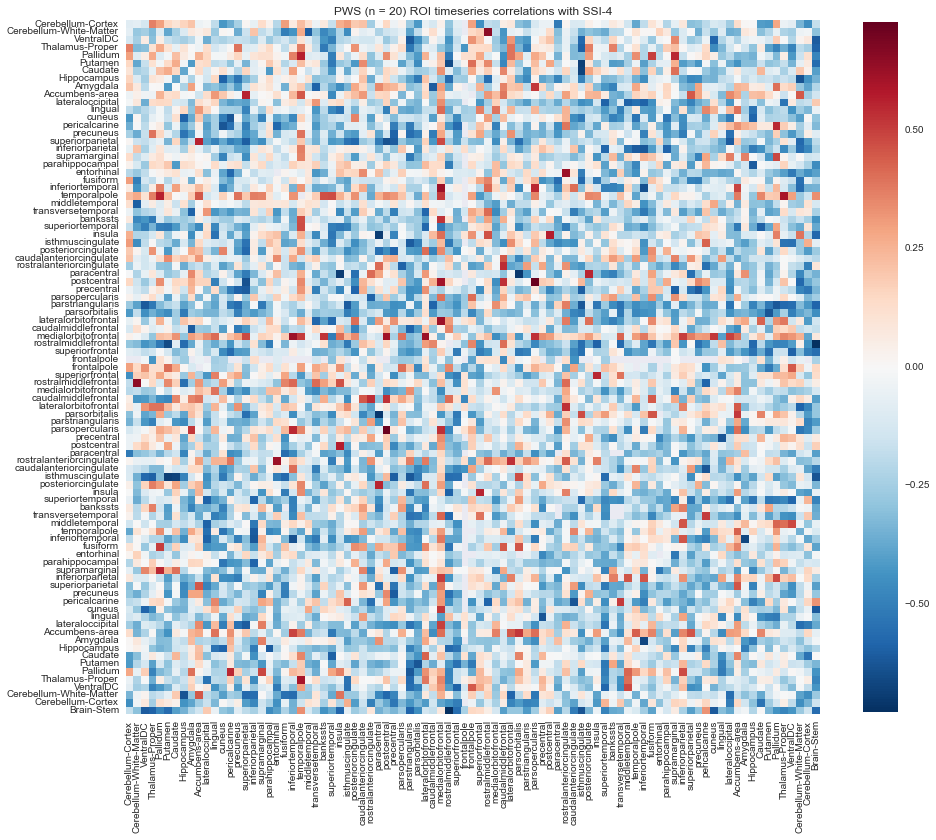

In [89]:
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('PWS (n = %d) ROI timeseries correlations with SSI-4'%(20))
sns.color_palette("RdBu_r")
sns.heatmap(corrout_symm, square=True, ax=ax, xticklabels=roi_list_sh,yticklabels=roi_list_sh,cbar_kws={'shrink':0.73})
f.tight_layout()